In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [4]:
import findspark
findspark.init()

In [5]:
# Importing the required packages 
from pyspark.ml.classification import (LogisticRegression, RandomForestClassifier, NaiveBayes)
from pyspark.ml.evaluation import (BinaryClassificationEvaluator, MulticlassClassificationEvaluator)
from pyspark.ml import Pipeline
from pyspark.ml.feature import (VectorAssembler, StringIndexer) 
from pyspark.ml.stat import Correlation
from pyspark.sql.types import FloatType
import pyspark.sql.functions as x
from pyspark.sql.functions import col, count, isnan, when

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [7]:
# installing package to plot histogram
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [8]:
#Creating spark context-Its like connecting to spark cluster
from pyspark import SparkConf 
from pyspark.context import SparkContext 
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

In [9]:
!pip install pyspark_dist_explore

In [10]:
from pyspark_dist_explore import hist

In [11]:
#importing the Data File into Google Colab
from google.colab import files
files.upload()

Saving Raisin_Dataset.csv to Raisin_Dataset.csv


{'Raisin_Dataset.csv': b'"Area","MajorAxisLength","MinorAxisLength","Eccentricity","ConvexArea","Extent","Perimeter","Class"\n"87524","442.2460114","253.291155","0.819738392","90546","0.758650579","1184.04","Kecimen"\n"75166","406.690687","243.0324363","0.801805234","78789","0.68412957","1121.786","Kecimen"\n"90856","442.2670483","266.3283177","0.798353619","93717","0.637612812","1208.575","Kecimen"\n"45928","286.5405586","208.7600423","0.684989217","47336","0.699599385","844.162","Kecimen"\n"79408","352.1907699","290.8275329","0.56401133","81463","0.792771926","1073.251","Kecimen"\n"49242","318.125407","200.12212","0.777351277","51368","0.658456354","881.836","Kecimen"\n"42492","310.1460715","176.1314494","0.823098681","43904","0.665893562","823.796","Kecimen"\n"60952","332.4554716","235.429835","0.706057518","62329","0.74359819","933.366","Kecimen"\n"42256","323.1896072","172.5759261","0.845498789","44743","0.698030924","849.728","Kecimen"\n"64380","366.9648423","227.7716147","0.7840

In [12]:
# Loading the csv file
df = spark.read.csv('Raisin_Dataset.csv',inferSchema=True, header =True)

In [13]:
# Printing the dataframe Schema, data types
df.printSchema()

root
 |-- Area: integer (nullable = true)
 |-- MajorAxisLength: double (nullable = true)
 |-- MinorAxisLength: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- ConvexArea: integer (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- Class: string (nullable = true)



In [14]:
# Printing the top 10 rows of the dataFrame
df.show(10)

+-----+---------------+---------------+------------+----------+-----------+---------+-------+
| Area|MajorAxisLength|MinorAxisLength|Eccentricity|ConvexArea|     Extent|Perimeter|  Class|
+-----+---------------+---------------+------------+----------+-----------+---------+-------+
|87524|    442.2460114|     253.291155| 0.819738392|     90546|0.758650579|  1184.04|Kecimen|
|75166|     406.690687|    243.0324363| 0.801805234|     78789| 0.68412957| 1121.786|Kecimen|
|90856|    442.2670483|    266.3283177| 0.798353619|     93717|0.637612812| 1208.575|Kecimen|
|45928|    286.5405586|    208.7600423| 0.684989217|     47336|0.699599385|  844.162|Kecimen|
|79408|    352.1907699|    290.8275329|  0.56401133|     81463|0.792771926| 1073.251|Kecimen|
|49242|     318.125407|      200.12212| 0.777351277|     51368|0.658456354|  881.836|Kecimen|
|42492|    310.1460715|    176.1314494| 0.823098681|     43904|0.665893562|  823.796|Kecimen|
|60952|    332.4554716|     235.429835| 0.706057518|     623

In [15]:
#Summary statistics on every column
print("Summary Statistics on every column of dataframe")
describe_stats = df.describe()
print(describe_stats.show())

Summary Statistics on every column of dataframe
+-------+-----------------+------------------+------------------+-------------------+-----------------+-------------------+------------------+-------+
|summary|             Area|   MajorAxisLength|   MinorAxisLength|       Eccentricity|       ConvexArea|             Extent|         Perimeter|  Class|
+-------+-----------------+------------------+------------------+-------------------+-----------------+-------------------+------------------+-------+
|  count|              900|               900|               900|                900|              900|                900|               900|    900|
|   mean|87804.12777777777|430.92995049844484|254.48813290322187|  0.781542150033333|         91186.09| 0.6995079264077781|1165.9066355555549|   null|
| stddev|39002.11139007146| 116.0351206246894| 49.98890170571766|0.09031840993160663|40769.29013198778|0.05346820028815931| 273.7643154160192|   null|
|    min|            25387|        225.629541|

In [16]:
# Checking for null values
df.select([x.count(x.when(x.isnull(c), c)).alias(c) for c in df.columns]).show()

+----+---------------+---------------+------------+----------+------+---------+-----+
|Area|MajorAxisLength|MinorAxisLength|Eccentricity|ConvexArea|Extent|Perimeter|Class|
+----+---------------+---------------+------------+----------+------+---------+-----+
|   0|              0|              0|           0|         0|     0|        0|    0|
+----+---------------+---------------+------------+----------+------+---------+-----+



Text(0.5, 1.0, 'Histogram plot for Area')

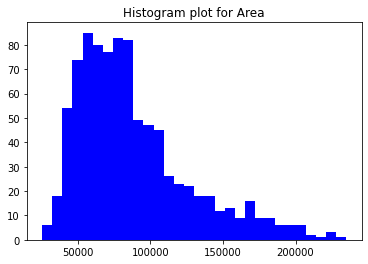

In [17]:
fig, ax = plt.subplots()
hist(ax,df.select("Area"), bins = 30, color=['blue'])
ax.set_title('Histogram plot for Area')

Pairwise Plots


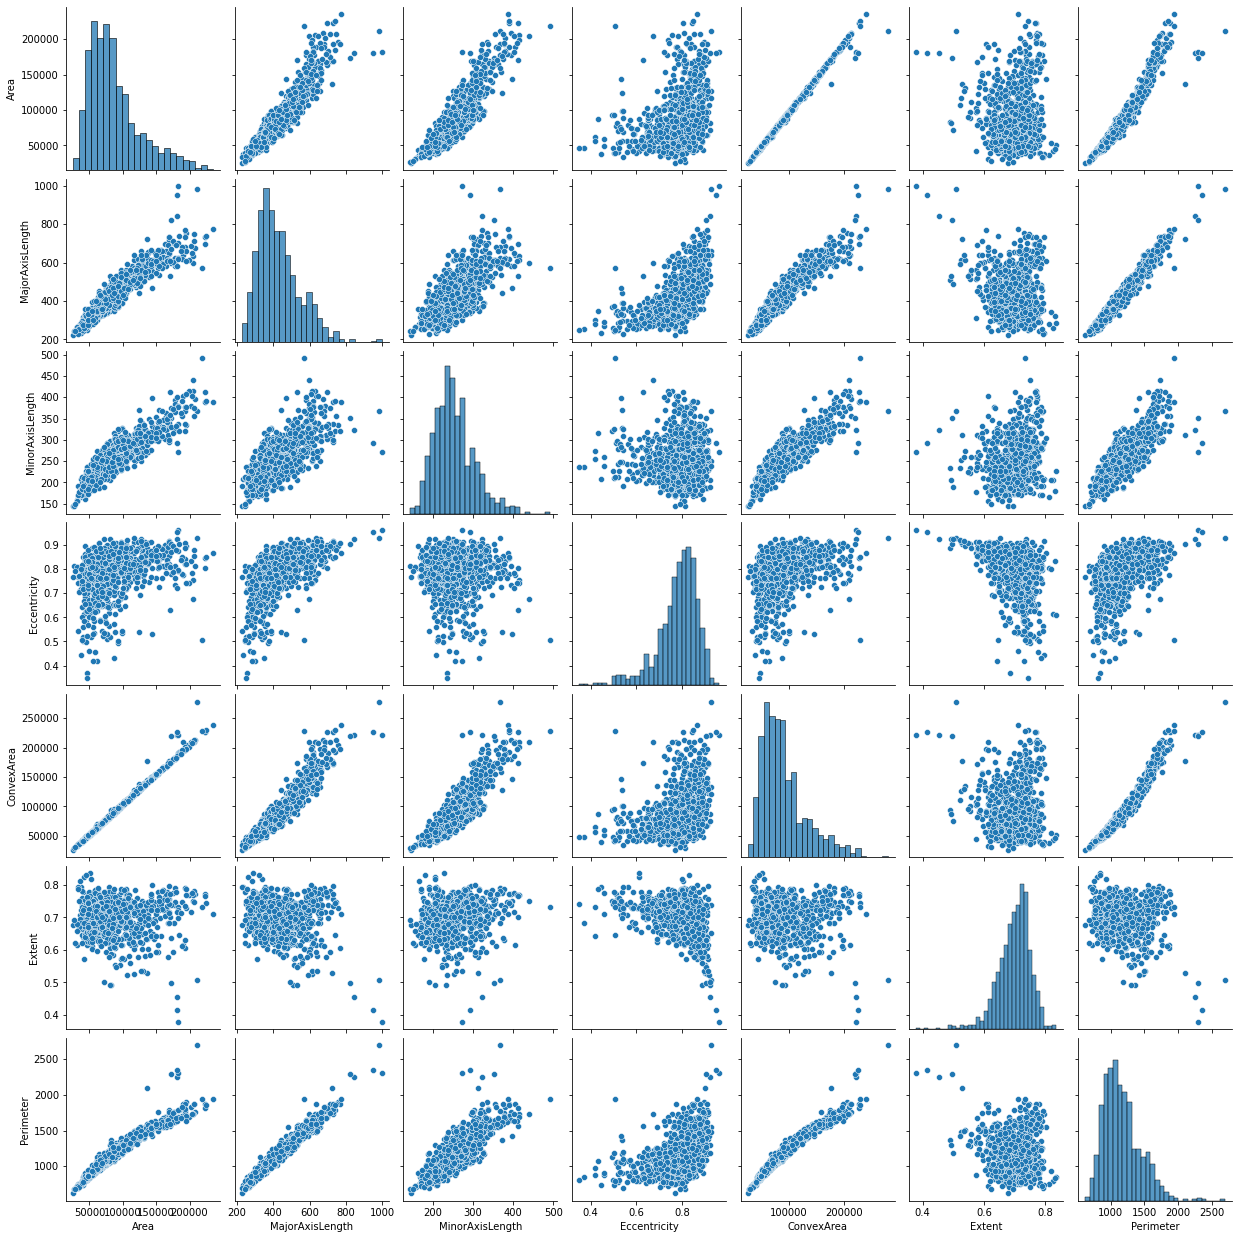

In [18]:
# Plotting the pairplot
print("Pairwise Plots")
import seaborn as sns
sns.pairplot(df.toPandas())

In [19]:
#Target variable values
target_counts = df.groupby('Class').count()
print("Target value counts of each category:")
target_counts.show()

Target value counts of each category:
+-------+-----+
|  Class|count|
+-------+-----+
|Kecimen|  450|
|  Besni|  450|
+-------+-----+



In [20]:
from matplotlib.backends.backend_pdf import PdfPages

boxplots of numeric columns


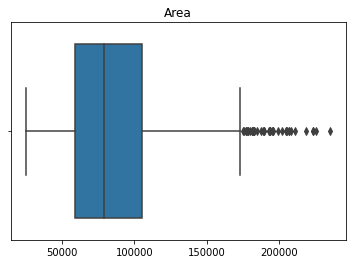

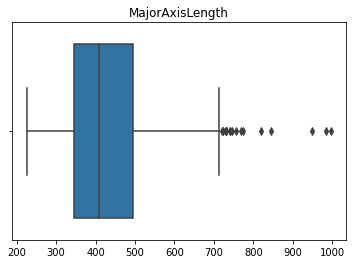

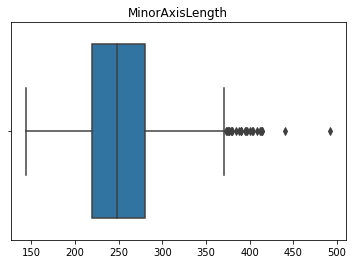

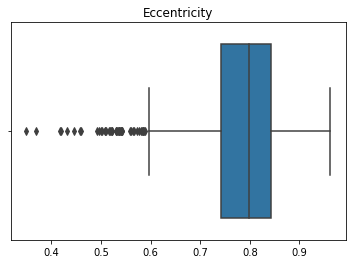

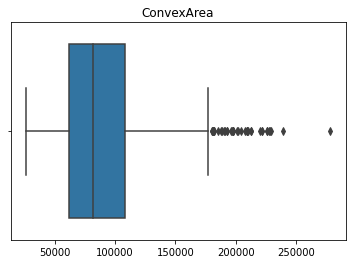

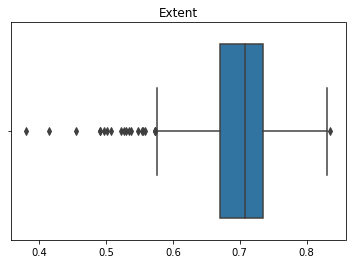

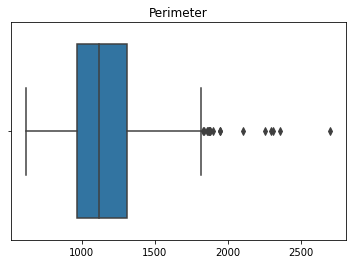

In [21]:
#Plotting the Box plots
print("boxplots of numeric columns")
df1 = df.drop('Class')
with PdfPages('Numeric_boxplots.pdf') as pdf:
  for i in df1.columns:
    l = df1.select(i).collect()
    l = [r[0] for r in l]
    plt.figure()
    b = sns.boxplot(x = l)
    plt.title(i)
    plt.show()
    pdf.savefig(b.get_figure())



In [22]:
#Generating the Corelation Matrix 
columnsData=df1.columns
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=columnsData, outputCol=vector_col)
myGraph_vector = assembler.transform(df1)
matrix1 = Correlation.corr(myGraph_vector, vector_col).collect()[0][0]
corrmatrix = matrix1.toArray().tolist()
print("The generated Correlation Matrix is:: \n {0}".format(corrmatrix))


The generated Correlation Matrix is:: 
 [[1.0, 0.9327744303604324, 0.9066498736938733, 0.33610660294618966, 0.995919666269527, -0.013499343486008277, 0.9613517233816234], [0.9327744303604324, 1.0, 0.7280302247108704, 0.5836083822572472, 0.9450309280407119, -0.20386555788117514, 0.9779780330970138], [0.9066498736938733, 0.7280302247108704, 1.0, -0.027683497208591184, 0.8956513247812773, 0.14532153123474034, 0.8274169744909121], [0.33610660294618966, 0.5836083822572472, -0.027683497208591184, 1.0, 0.34821029603071446, -0.36106149402568116, 0.447845159978163], [0.995919666269527, 0.9450309280407119, 0.8956513247812773, 0.34821029603071446, 1.0, -0.05480246817178326, 0.9766122302679476], [-0.013499343486008277, -0.20386555788117514, 0.14532153123474034, -0.36106149402568116, -0.05480246817178326, 1.0, -0.17344892677382867], [0.9613517233816234, 0.9779780330970138, 0.8274169744909121, 0.447845159978163, 0.9766122302679476, -0.17344892677382867, 1.0]]


/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


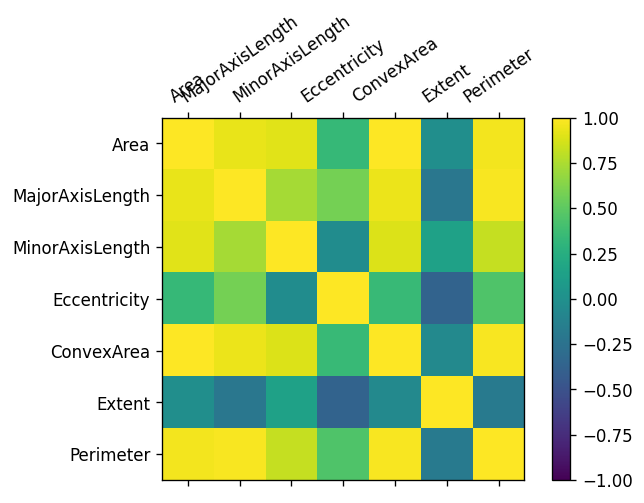

In [23]:
# Generating the HeatMap of the Data
figure=plt.figure(1)
figure1=figure.add_subplot(111)
figure1.set_xticklabels(['']+columnsData, rotation = 35)
figure1.set_yticklabels(['']+columnsData)
figure.colorbar(figure1.matshow(corrmatrix,vmax=1,vmin=-1))
figure.set_dpi(120)
plt.show()

In [24]:
# Dropping highly correlated columns
cols = ["MajorAxisLength", "MinorAxisLength", "ConvexArea", "Perimeter"]
df = df.drop(*cols)

In [25]:
df.printSchema()

root
 |-- Area: integer (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Class: string (nullable = true)



In [26]:
#splitting data into train and test sets
train_df, test_df = df.randomSplit([.7,.3])

In [27]:
label = 'Class'
numerical_cols = ['Area', 'Eccentricity','Extent']

In [28]:
# Indexer for classification label:
label_indexer = StringIndexer(inputCol=label, outputCol=label+'_indexed')

In [29]:
#assemble all features as vector to be used as input for Spark MLLib
assembler = VectorAssembler(inputCols= numerical_cols, outputCol='features')

In [30]:
# Creating data processing pipeline
pipeline = Pipeline(stages= [label_indexer, assembler])

In [31]:
lr = LogisticRegression(featuresCol='features', labelCol=label+'_indexed')
rfc = RandomForestClassifier(featuresCol='features', labelCol=label+'_indexed', numTrees=100)
nb = NaiveBayes(featuresCol='features', labelCol=label+'_indexed')

In [32]:
# creating pipelines with machine learning models
pipeline_lr = Pipeline(stages=[pipeline, lr])
pipeline_rfc = Pipeline(stages=[pipeline, rfc])
pipeline_nb = Pipeline(stages=[pipeline, nb])

In [33]:
#fitting models with train subset
lr_fit = pipeline_lr.fit(train_df)
rfc_fit = pipeline_rfc.fit(train_df)
nb_fit = pipeline_nb.fit(train_df)

In [34]:
# predictions for test subset
pred_lr = lr_fit.transform(test_df)
pred_rfc = rfc_fit.transform(test_df)
pred_nb = nb_fit.transform(test_df)

In [35]:
pred_AUC = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol=label+'_indexed')

In [36]:
AUC_lr = pred_AUC.evaluate(pred_lr)
AUC_rfc = pred_AUC.evaluate(pred_rfc)
AUC_nb = pred_AUC.evaluate(pred_nb)
print("The Area Under the curve for Logistic Regression, Random Forest, Naive Bayes")
print(AUC_lr, AUC_rfc, AUC_nb)

The Area Under the curve for Logistic Regression, Random Forest, Naive Bayes
0.8580482897384305 0.8545271629778671 0.7798289738430584


In [37]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol=label+'_indexed', predictionCol="prediction", metricName="accuracy")


In [38]:
acc_lr = acc_evaluator.evaluate(pred_lr)
acc_rfc = acc_evaluator.evaluate(pred_rfc)
acc_nb = acc_evaluator.evaluate(pred_nb)
 
print('Logistic Regression accuracy: ', '{:.2f}'.format(acc_lr*100), '%', sep='')
print('Random Forest accuracy: ', '{:.2f}'.format(acc_rfc*100), '%', sep='')
print('Naive Bayes accuracy: ', '{:.2f}'.format(acc_nb*100), '%', sep='')

Logistic Regression accuracy: 85.82%
Random Forest accuracy: 85.46%
Naive Bayes accuracy: 78.01%
